# Step 5: Dealing with non-stationary environments with two abrupt changes
Assume that all the properties of the graph are known except for the edge activation
probabilities. Assume that the edge activation probabilities are non-stationary, being subject
to seasonal phases (3 different phases spread over 365 days). Provide motivation for the
phases. Apply the greedy algorithm to the problem of maximizing the expected number of
activated customers, where each edge activation probability is replaced with its upper
confidence bound (in a UCB1-like fashion). Moreover, apply two non-stationary flavors of the
algorithm. The first one is passive and exploits a sliding window, while the second one is
active and exploits a change detection test. Provide a sensitivity analysis of the algorithms,
evaluating different values of the length of the sliding window in the first case and different
values for the parameters of the change detection test in the second case. Report the plots
of the average value and standard deviation of the cumulative regret, cumulative reward,
instantaneous regret, and instantaneous reward.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
from tqdm import tqdm
import random


In [2]:

class Environment:
    def __init__(self, probabilities):
        self.probabilities = probabilities

    def round(self, pulled_arm):
        reward = np.random.binomial(1, self.probabilities[pulled_arm])
        return reward

In [3]:
import numpy as np
from tqdm import tqdm

def simulate_episode(init_prob_matrix, seeds:list, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    #set up seeds
    active_nodes=np.zeros(n_nodes)

    for seed in seeds:
        active_nodes[seed]=1

    history=np.array([active_nodes])

    newly_active_nodes=active_nodes

    t=0

    while (t<max_steps and np.sum(newly_active_nodes)>0):
        #retrieve probability of edge activations
        p = (prob_matrix.T*active_nodes).T
        activated_edges=p>np.random.rand(p.shape[0], p.shape[1])
        #remove activated edges
        prob_matrix=prob_matrix*((p!=0)==activated_edges)
        #update active nodes
        newly_active_nodes=(np.sum(activated_edges, axis=0)>0)*(1-active_nodes)
        #print(newly_active_nodes)
        active_nodes=np.array(active_nodes+newly_active_nodes)
        #print(active_nodes)
        history=np.concatenate((history, [newly_active_nodes]), axis=0)
        t+=1
    return history, active_nodes

def test_seed(seeds, prob_matrix, k, max_steps):
    reward = 0
    for i in range(k):
        history, active_nodes=simulate_episode(prob_matrix, seeds, max_steps)
        reward+=np.sum(active_nodes)
    return reward/k

def greedy_algorithm(init_prob_matrix, budget, k, max_steps):
    prob_matrix=init_prob_matrix.copy()
    n_nodes=prob_matrix.shape[0]

    seeds=[]
    for j in range(budget):
        print('Choosing seed ', j+1, '...')
        rewards=np.zeros(n_nodes)

        for i in tqdm(range(n_nodes)):
            if i not in seeds:
                rewards[i]=test_seed([i]+seeds, prob_matrix, k, max_steps)
        seeds.append(np.argmax(rewards))

    return seeds

In [4]:
class MatchingEnvironment(Environment):
    def __init__(self, reward_matrix):
        self.reward_matrix = reward_matrix
        # add a row and a column of zeros to the reward matrix to represent the case in which no match is made
        self.reward_matrix = np.hstack((self.reward_matrix, np.zeros((self.reward_matrix.shape[0], 1))))
        self.reward_matrix = np.vstack((self.reward_matrix, np.zeros((1, self.reward_matrix.shape[1]))))

        self.n_arms = reward_matrix.size
        self.t = 0

    def round(self, pulled_arms):
        try:
            rewards = [self.reward_matrix[pulled_arm] for pulled_arm in pulled_arms]
        except:
            print(pulled_arms)
        #iterate through all cells of rewards, if a cell is callable, call it and replace it with the result
        for i in range(len(rewards)):
            if callable(rewards[i]):
                rewards[i] = rewards[i]()

        return np.array(rewards)

In [5]:
class NonStationaryEnvironment(Environment):
    def __init__(self, probabilities, horizon):
        super().__init__(probabilities)
        self.t=0
        n_phases = len(self.probabilities)
        self.phase_size = horizon / n_phases

    def round(self, pulled_arm):
        current_phase = int(self.t / self.phase_size)
        p = self.probabilities[current_phase][pulled_arm]
        reward = np.random.binomial(1, p)
        self.t += 1
        return reward

## Learners

In [6]:

class Learner:

    def __init__(self, n_arms) -> None:
        self.n_arms = n_arms
        self.t = 0
        self.rewards_per_arm = x = [[] for i in range(n_arms)]
        self.collected_rewards = np.array([])

    def update_observations(self, pulled_arm, reward):
        self.rewards_per_arm[pulled_arm].append(reward)
        self.collected_rewards = np.append(self.collected_rewards, reward)
        self.t += 1

In [7]:
class UCBLearner(Learner):
    def __init__(self, n_arms):
        super().__init__(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.n_pulls = np.zeros(n_arms)  # count the number of times each arm has been pulled
        self.confidence = np.array([np.inf] * n_arms)

    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.n_pulls[pulled_arm] += 1
        self.empirical_means[pulled_arm] = (self.empirical_means[pulled_arm] * (self.n_pulls[pulled_arm] - 1) + reward) / self.n_pulls[pulled_arm]
        for a in range(self.n_arms):
            #n_samples = max(1, self.n_pulls[a])
            n_samples = self.n_pulls[a]
            self.confidence[a] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else np.inf

        self.update_observations(pulled_arm, reward)

In [8]:
class SW_UCBLearner(UCBLearner):
    def __init__(self, n_arms, window_size):
        super().__init__(n_arms)
        self.window_size = window_size
        # array showing sequence of pulled arms
        self.pulled_arms = np.array([])



    # get the list of unplayed arm in the last time_window
    def get_unplayed_arms(self, pulled_arms, time_window):
      all_arms = [i for i in range(self.n_arms)]
      if len(pulled_arms) < time_window:
        return list(all_arms)
      else:
        last_time_window = pulled_arms[-time_window:]
        played_arms = set(last_time_window)
        all_arms = [i for i in range(self.n_arms)]
        unplayed_arms = set(all_arms) - played_arms
        return list(unplayed_arms)


    def pull_arm(self):
        upper_confidence_bound = self.empirical_means + self.confidence

        self.upper_confidence_bound = upper_confidence_bound

        arms = [i for i in range(n_arms)] # get a list of all arms
        unplayed_arms_in_window = self.get_unplayed_arms(self.pulled_arms, self.window_size)
        # if there are unplayed arms in the most recent time window, play one of them at random
        if unplayed_arms_in_window != []:
            return random.choice(unplayed_arms_in_window)
        # else play the one with highest confidence bound
        else:
            return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])

    def update(self, pulled_arm, reward):
        self.t += 1
        self.pulled_arms = np.append(self.pulled_arms, pulled_arm)

        for arm in range(self.n_arms):
            # count the number of times the arm has been played in the window
            n_samples = np.count_nonzero(np.array(self.pulled_arms[-window_size:]) == arm)
            # get the cumulative reward for the window if the arm was played at least once in the window
            cum_reward_in_window = np.sum(self.rewards_per_arm[arm][-n_samples:]) if n_samples > 0 else 0
            # empirical mean is computed
            self.empirical_means[arm] = cum_reward_in_window / n_samples if n_samples > 0 else 0
            # confidence decreasing linearly with number of samples in window
            self.confidence[arm] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else 1000

        self.update_observations(pulled_arm, reward)

    def expectations(self):
        return self.empirical_means


In [9]:
class CUSUM:
  def __init__(self, M, eps, h):
    self.M = M #Length of window considered by CD
    self.eps = eps #Epsylon
    self.h = h #Threshold
    self.t = 0
    self.reference = 0 #Reference Mean
    self.g_plus = 0
    self.g_minus = 0

  def update(self, sample):
    self.t += 1


    # If time < CD window, update reference mean with new sample and return 0
    if self.t <= self.M:
      self.reference += sample/self.M
      return 0

    # If time > CD window, compute deviations and their cumulative sum
    else:
      s_plus = (sample - self.reference) - self.eps
      s_minus = -(sample - self.reference) - self.eps
      self.g_plus = max(0, self.g_plus + s_plus)
      self.g_minus = max(0, self.g_minus+ s_minus)
      # Return 1 if cusum of deviations are over threshold h
      return self.g_plus > self.h or self.g_minus > self.h

  def reset(self):
    # Reset the parameters if a detection occurs
    self.t = 0
    self.g_minus = 0
    self.g_plus = 0

  def Rounds_After_Last_Change(self):
    return self.t

In [10]:
class CUSUMUCB(UCBLearner):
    def __init__(self, n_arms, M=10, eps=0.01, h=5, alpha=0.1):
        super().__init__(n_arms)
        self.change_detection = [CUSUM(M, eps, h) for _ in range(n_arms)] #List of CUSUM objects
        self.detections = [[] for _ in range(n_arms)] # List of lists of detections per arm
        self.alpha = alpha
        self.pulled_arms = np.array([])
        # Initialize tau(a) as 0 for all arms.
        self.window_sizes = [0 for i in range(n_arms)]


    def pull_arm(self):
      upper_confidence_bound = self.empirical_means + self.confidence
      upper_confidence_bound[np.isinf(upper_confidence_bound)] = 1e3

      if np.random.binomial(1,1-self.alpha):
        return np.random.choice(np.where(upper_confidence_bound == upper_confidence_bound.max())[0])
      else:
        return random.randint(0,n_arms-1)




    def update(self, pulled_arm, reward):
      self.t += 1
      self.pulled_arms = np.append(self.pulled_arms, pulled_arm)

              # Update the change detection for the arm pulled
      if self.change_detection[pulled_arm].update(reward):
        self.change_detection[pulled_arm].reset()


      for arm in range(self.n_arms):
        # update window_sizes for each arm
        self.window_sizes[arm] = self.change_detection[arm].Rounds_After_Last_Change()
        # count the number of times the arm has been played in the window
        n_samples = np.count_nonzero(np.array(self.pulled_arms[-self.window_sizes[arm]:]) == arm)
        # get the cumulative reward for the window if the arm was played at least once in the window
        cum_reward_in_window = np.sum(self.rewards_per_arm[arm][-n_samples:]) if n_samples > 0 else 0
        # empirical mean is computed
        self.empirical_means[arm] = cum_reward_in_window / n_samples if n_samples > 0 else 0
        # confidence decreasing linearly with number of samples in window
        self.confidence[arm] = np.sqrt(2 * np.log(self.t) / n_samples) if n_samples > 0 else 1000


      self.update_observations(pulled_arm, reward)

    def expectations(self):
      return self.empirical_means

In [11]:
def hungarian_algorithm(matrix):
    m = matrix.copy()
    n_rows, n_cols = m.shape
    max_val = np.max(m)

    if n_rows > n_cols:
        m = np.pad(m, ((0, 0), (0, n_rows - n_cols)), mode='constant', constant_values=max_val)
    elif n_cols > n_rows:
        m = np.pad(m, ((0, n_cols - n_rows), (0, 0)), mode='constant', constant_values=max_val)

    assigned_rows, assigned_cols = linear_sum_assignment(m)

    assignment = np.zeros_like(m, dtype=int)
    assignment[assigned_rows, assigned_cols] = 1

    return assignment[:n_rows, :n_cols] * matrix, assignment[:n_rows, :n_cols]

def generate_reward(mean, std_dev):
    return lambda: np.random.normal(mean, std_dev)

In [134]:

def get_reward(node_class, product_class, rewards_parameters):
    return 100-np.random.normal(rewards_parameters[0][node_class-1, product_class], rewards_parameters[1][node_class-1, product_class])

def clairvoyant(graph_probabilities, true_prob, customer_assignments, rewards_parameters, real_reward_parameters, n_exp, seeds=None):
    hungarian_matrix = hungarian_algorithm(rewards_parameters[0])[1]

    reward_per_experiment = [[] for i in range(n_exp)]

    if seeds == None:
        opt_seeds = greedy_algorithm(graph_probabilities, 3, 100, 100)
    else:
        opt_seeds = seeds

    for e in tqdm(range(n_exp)):

        history = simulate_episode(true_prob, opt_seeds, 10)[0]
        activation_flow = np.concatenate([np.where(row == 1)[0] for row in history]).tolist()
        class_activation_flow = customer_assignments[activation_flow]
        exp_reward = 0

        units = [3, 3, 3]

        while units != [0, 0, 0]:

            for customer in class_activation_flow:

                # Find mean of matching reward
                nonzero_index = np.nonzero(hungarian_matrix[customer])
                product_class = int(nonzero_index[0][0])

                if units[product_class] != 0:
                    reward = get_reward(customer, product_class, real_reward_parameters)
                    units[product_class] = units[product_class] - 1

                else:
                    instock_units = [index for index, value in enumerate(units) if value != 0]
                    if instock_units:  # Check if instock_units is not empty before choosing
                        product_class = random.choice(instock_units)
                        reward = get_reward(customer, product_class, real_reward_parameters)
                        units[product_class] -= 1
                    else:
                        # Handle the case when units is empty (no available units)
                        reward = 0

                exp_reward = exp_reward + reward

            reward_per_experiment[e] = exp_reward

    return np.mean(reward_per_experiment), np.std(reward_per_experiment)

## SCENARIO SET UP

#### Classes of product and Classes of customers

In [13]:
node_classes = 3
product_classes = 3
products_per_class = 3

means = np.random.uniform(10, 20, (3,3))
std_dev = np.ones((3,3))
rewards_parameters = (means, std_dev)

customer_assignments = np.random.choice([0,1,2], size=30)

#### Probability tables for each phase

In [14]:
n_arms = 30
n_phases = 3,
T = 365
window_size = int(T**0.5)
n_experiments = 50

def generate_graph_probabilities(n_nodes, edge_rate):
    graph_structure = np.random.binomial(1, edge_rate, (n_nodes, n_nodes))
    graph_probabilities = np.random.uniform(0.1, 0.9, (n_nodes, n_nodes)) * graph_structure
    return graph_probabilities

n_nodes = 30
edge_rate = 0.05
n_phases = 3

prob_phase1 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(30,30))
prob_phase2 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(30,30))
prob_phase3 = np.reshape(generate_graph_probabilities(n_nodes=n_nodes,edge_rate=edge_rate),(30,30))

# Array containing three (30*30) different probabilities tables.
p = np.stack((prob_phase1, prob_phase2, prob_phase3), axis=0)


# Array K will contain 30 arrays containing each 3 rows: row[i] of probability table of phase1, row[i] of the one of phase2, row[i] of the one of phase3.
K = np.array([p[:, i] for i in range(p.shape[1])])



## Probability Estimators

In [15]:
def SW_Generate_Probability_Estimates(p, n_arms=n_arms, n_phases=n_phases, T=T, window_size=window_size, n_experiments=n_experiments):
    phases_len = int(T / n_phases)
    swucb_rewards_per_experiment = []

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        swucb_env = NonStationaryEnvironment(probabilities=p, horizon=T)
        # Initialize learner
        swucb_learner = SW_UCBLearner(n_arms=n_arms, window_size=window_size)

        for t in range(0, T):
            # SW-UCB Learner
            pulled_arm = swucb_learner.pull_arm()
            reward = swucb_env.round(pulled_arm)
            swucb_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = swucb_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

In [16]:
def CUSUM_Generate_Probability_Estimates(p, n_arms=n_arms, n_phases=n_phases, T=T, n_experiments=n_experiments):
    phases_len = int(T / n_phases)
    cusum_rewards_per_experiment = []

    experimentS_means_at_each_round = np.empty((n_experiments, T, n_arms))

    for e in tqdm(range(0, n_experiments)):
        # Initialize environment
        cusum_env = NonStationaryEnvironment(probabilities=p, horizon=T)
        # Initialize learner
        cusum_learner = CUSUMUCB(n_arms=n_arms)

        for t in range(0, T):
            # SW-UCB Learner
            pulled_arm = cusum_learner.pull_arm()
            reward = cusum_env.round(pulled_arm)
            cusum_learner.update(pulled_arm, reward)

            # At each round memorize a copy of the means of each arm
            expected_rew = cusum_learner.expectations()
            experimentS_means_at_each_round[e, t] = expected_rew.copy()

    return experimentS_means_at_each_round

#### Estimating edges' probabilities with SW


In [17]:
SW_rounds_probabilities_for_each_arm = []

for index in range(len(K)):
    print("Learning for row:",index)
    estimates = SW_Generate_Probability_Estimates(K[index])
    SW_rounds_probabilities_for_each_arm.append(estimates)

SW_rounds_probabilities_for_each_arm = np.mean(SW_rounds_probabilities_for_each_arm, axis=1)

Learning for row: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.91it/s]


Learning for row: 1


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.70it/s]


Learning for row: 2


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.83it/s]


Learning for row: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.92it/s]


Learning for row: 4


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.71it/s]


Learning for row: 5


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.86it/s]


Learning for row: 6


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.73it/s]


Learning for row: 7


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.82it/s]


Learning for row: 8


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.84it/s]


Learning for row: 9


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.82it/s]


Learning for row: 10


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.85it/s]


Learning for row: 11


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.65it/s]


Learning for row: 12


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.78it/s]


Learning for row: 13


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.83it/s]


Learning for row: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.83it/s]


Learning for row: 15


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.77it/s]


Learning for row: 16


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.74it/s]


Learning for row: 17


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.89it/s]


Learning for row: 18


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.87it/s]


Learning for row: 19


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.73it/s]


Learning for row: 20


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:09<00:00,  5.06it/s]


Learning for row: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.79it/s]


Learning for row: 22


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.74it/s]


Learning for row: 23


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.76it/s]


Learning for row: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.75it/s]


Learning for row: 25


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.77it/s]


Learning for row: 26


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.72it/s]


Learning for row: 27


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.73it/s]


Learning for row: 28


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.87it/s]


Learning for row: 29


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  2.99it/s]


#### Estimating edges' probabilities with CUSUM


In [18]:
CUSUM_rounds_probabilities_for_each_arm = []

for index in range(len(K)):
    print("Learning for row:",index)
    estimates = CUSUM_Generate_Probability_Estimates(K[index])
    CUSUM_rounds_probabilities_for_each_arm.append(estimates)

CUSUM_rounds_probabilities_for_each_arm = np.mean(CUSUM_rounds_probabilities_for_each_arm, axis=1)

Learning for row: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.46it/s]


Learning for row: 1


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.57it/s]


Learning for row: 2


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.46it/s]


Learning for row: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.49it/s]


Learning for row: 4


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.56it/s]


Learning for row: 5


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.34it/s]


Learning for row: 6


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.69it/s]


Learning for row: 7


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.34it/s]


Learning for row: 8


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.60it/s]


Learning for row: 9


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.39it/s]


Learning for row: 10


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.36it/s]


Learning for row: 11


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.37it/s]


Learning for row: 12


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.48it/s]


Learning for row: 13


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:11<00:00,  4.29it/s]


Learning for row: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:10<00:00,  4.83it/s]


Learning for row: 15


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.35it/s]


Learning for row: 16


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.43it/s]


Learning for row: 17


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.70it/s]


Learning for row: 18


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.46it/s]


Learning for row: 19


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.32it/s]


Learning for row: 20


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.86it/s]


Learning for row: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.55it/s]


Learning for row: 22


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.35it/s]


Learning for row: 23


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.56it/s]


Learning for row: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.50it/s]


Learning for row: 25


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.74it/s]


Learning for row: 26


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.40it/s]


Learning for row: 27


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.33it/s]


Learning for row: 28


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.32it/s]


Learning for row: 29


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.78it/s]


In [19]:

def Reshape(LIST):
  # Convert the lists into a NumPy array
  array_of_lists = np.array(LIST)
  # Transpose the array to swap the axes
  transposed_array = array_of_lists.T
  # Split the transposed array into separate arrays along axis=1
  return np.split(transposed_array, transposed_array.shape[1], axis=1)


In [20]:
estimated_tables_SW = Reshape(SW_rounds_probabilities_for_each_arm)
estimated_tables_CUSUM = Reshape(CUSUM_rounds_probabilities_for_each_arm)

In [92]:
phases_array = np.empty((T, n_nodes, n_nodes))
T = 365
phases_len = int(T / n_phases)

for t in range(T):
    if t <= 121:
        phases_array[t] = p[0]
    if t in range(121, 243):
        phases_array[t] = p[1]
    if t >243:
        phases_array[t] = p[2]


array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.29428344, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.21284929, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.85495978, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.88373684, 0.        , 0.        , 0.

#### Regret in activation probability estimation

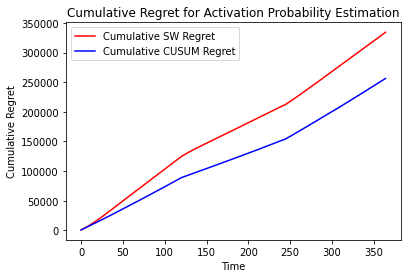

In [192]:


sw_diff = []
cusum_diff = []
opt = []

cumulative_sw_regret = 0
cumulative_cusum_regret = 0

for index in range(len(phases_array)):
    sw_difference = np.abs(phases_array[index] - estimated_tables_SW[index])
    sw_tot_difference = np.sum(sw_difference)
    cumulative_sw_regret += sw_tot_difference
    sw_diff.append(cumulative_sw_regret)
    
    cusum_difference = np.abs(phases_array[index] - estimated_tables_CUSUM[index])
    cusum_tot_difference = np.sum(cusum_difference)
    cumulative_cusum_regret += cusum_tot_difference
    cusum_diff.append(cumulative_cusum_regret)
    

plt.plot(sw_diff, color='red', label='Cumulative SW Regret')
plt.plot(cusum_diff, color='blue', label='Cumulative CUSUM Regret')

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret for Activation Probability Estimation')

# Add a legend
plt.legend()

# Show the plot
plt.show()


### COMPUTING REWARDS

### Reward - SW_UCB

In [110]:
n_exp = 10

SW_mean_rewards_per_round = []
SW_std_dev_rewards_per_round = []
for table in tqdm(range(len(estimated_tables_SW))):
    true_p = phases_array[table]
    table = np.reshape(estimated_tables_SW[table],(30,30))
    clairvoyant_output = clairvoyant(table, true_p, customer_assignments, rewards_parameters, rewards_parameters, n_exp)
    SW_mean_rewards_per_round.append(clairvoyant_output[0])
    SW_std_dev_rewards_per_round.append(clairvoyant_output[1])


  0%|                                                                                          | 0/365 [00:00<?, ?it/s]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.89it/s]


Choosing seed  2 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.85it/s]


Choosing seed  3 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 134.32it/s]

  0%|▏                                                                                 | 1/365 [00:00<04:55,  1.23it/s]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.72it/s]


Choosing seed  2 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.07it/s]


Choosing seed  3 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 116.50it/s]

  1%|▍                                                                                 | 2/365 [00:01<05:07,  1.18it/s]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.71it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.54it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.34it/s]

  1%|▋                                                                                 | 3/365 [00:02<05:17,  1.14it/s]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.15it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.19it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.50it/s]

  1%|▉                                                                                 | 4/365 [00:03<05:30,  1.09it/s]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.86it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.64it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.99it/s]

  1%|█                                                                                 | 5/365 [00:04<05:46,  1.04it/s]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.63it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.35it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.97it/s]

  2%|█▎                                                                                | 6/365 [00:05<05:54,  1.01it/s]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.02it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.08it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.89it/s]

  2%|█▌                                                                                | 7/365 [00:06<05:59,  1.01s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.42it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.89it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.13it/s]

  2%|█▊                                                                                | 8/365 [00:07<06:14,  1.05s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.49it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.72it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.41it/s]

  2%|██                                                                                | 9/365 [00:09<06:27,  1.09s/it]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.29it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.14it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.71it/s]

  3%|██▏                                                                              | 10/365 [00:10<06:47,  1.15s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.35it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.65it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.74it/s]

  3%|██▍                                                                              | 11/365 [00:11<06:50,  1.16s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.86it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.69it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.98it/s]

  3%|██▋                                                                              | 12/365 [00:12<06:54,  1.18s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.43it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.78it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.14it/s]

  4%|██▉                                                                              | 13/365 [00:14<07:21,  1.25s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.83it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.66it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.74it/s]

  4%|███                                                                              | 14/365 [00:15<07:35,  1.30s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.19it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.36it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.70it/s]

  4%|███▎                                                                             | 15/365 [00:16<07:39,  1.31s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.60it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.86it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.81it/s]

  4%|███▌                                                                             | 16/365 [00:18<07:59,  1.37s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.25it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.11it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.78it/s]

  5%|███▊                                                                             | 17/365 [00:19<08:16,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.22it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.44it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.39it/s]

  5%|███▉                                                                             | 18/365 [00:21<08:21,  1.45s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.83it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.32it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.07it/s]

  5%|████▏                                                                            | 19/365 [00:22<08:28,  1.47s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.58it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.99it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.85it/s]

  5%|████▍                                                                            | 20/365 [00:24<08:51,  1.54s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.15it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.55it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.30it/s]

  6%|████▋                                                                            | 21/365 [00:26<08:51,  1.54s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.15it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.85it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.19it/s]

  6%|████▉                                                                            | 22/365 [00:27<08:56,  1.56s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.31it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.36it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.05it/s]

  6%|█████                                                                            | 23/365 [00:29<08:54,  1.56s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.13it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.25it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.08it/s]

  7%|█████▎                                                                           | 24/365 [00:31<09:05,  1.60s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.09it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.80it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.69it/s]

  7%|█████▌                                                                           | 25/365 [00:32<09:07,  1.61s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.74it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.97it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.27it/s]

  7%|█████▊                                                                           | 26/365 [00:34<09:15,  1.64s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.55it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.90it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.12it/s]

  7%|█████▉                                                                           | 27/365 [00:36<09:13,  1.64s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.63it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.02it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.13it/s]

  8%|██████▏                                                                          | 28/365 [00:37<09:09,  1.63s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.01it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.46it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.07it/s]

  8%|██████▍                                                                          | 29/365 [00:39<09:11,  1.64s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.19it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.18it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.75it/s]

  8%|██████▋                                                                          | 30/365 [00:41<09:17,  1.67s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.52it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.98it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.79it/s]

  8%|██████▉                                                                          | 31/365 [00:42<09:15,  1.66s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.86it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.68it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.13it/s]

  9%|███████                                                                          | 32/365 [00:44<09:19,  1.68s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.90it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.74it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.70it/s]

  9%|███████▎                                                                         | 33/365 [00:46<09:35,  1.73s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.96it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.42it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.48it/s]

  9%|███████▌                                                                         | 34/365 [00:48<09:36,  1.74s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.66it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.36it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.79it/s]

 10%|███████▊                                                                         | 35/365 [00:49<09:30,  1.73s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.03it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.20it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.17it/s]

 10%|███████▉                                                                         | 36/365 [00:51<09:39,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.51it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.11it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.55it/s]

 10%|████████▏                                                                        | 37/365 [00:53<09:38,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.24it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.31it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.69it/s]

 10%|████████▍                                                                        | 38/365 [00:55<09:32,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.56it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.64it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.48it/s]

 11%|████████▋                                                                        | 39/365 [00:56<09:33,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.58it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.56it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.87it/s]

 11%|████████▉                                                                        | 40/365 [00:58<09:26,  1.74s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.70it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.65it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.33it/s]

 11%|█████████                                                                        | 41/365 [01:00<09:27,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.74it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.90it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.06it/s]

 12%|█████████▎                                                                       | 42/365 [01:02<09:19,  1.73s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.08it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.02it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.21it/s]

 12%|█████████▌                                                                       | 43/365 [01:03<09:26,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.45it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.61it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.73it/s]

 12%|█████████▊                                                                       | 44/365 [01:05<09:21,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.59it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.49it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.89it/s]

 12%|█████████▉                                                                       | 45/365 [01:07<09:19,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.14it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.18it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.62it/s]

 13%|██████████▏                                                                      | 46/365 [01:09<09:22,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.19it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.63it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.10it/s]

 13%|██████████▍                                                                      | 47/365 [01:10<09:19,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.96it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.38it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 37.12it/s]

 13%|██████████▋                                                                      | 48/365 [01:12<09:26,  1.79s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.93it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.07it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.66it/s]

 13%|██████████▊                                                                      | 49/365 [01:14<09:25,  1.79s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.83it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.85it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.45it/s]

 14%|███████████                                                                      | 50/365 [01:16<09:27,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.37it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.56it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.92it/s]

 14%|███████████▎                                                                     | 51/365 [01:18<09:24,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.72it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.32it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.46it/s]

 14%|███████████▌                                                                     | 52/365 [01:19<09:23,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.42it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.60it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.21it/s]

 15%|███████████▊                                                                     | 53/365 [01:21<09:28,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.43it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.45it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.19it/s]

 15%|███████████▉                                                                     | 54/365 [01:23<09:25,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.00it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.62it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.93it/s]

 15%|████████████▏                                                                    | 55/365 [01:25<09:25,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.38it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.67it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.09it/s]

 15%|████████████▍                                                                    | 56/365 [01:27<09:16,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.09it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.03it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.19it/s]

 16%|████████████▋                                                                    | 57/365 [01:29<09:20,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.98it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.52it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.74it/s]

 16%|████████████▊                                                                    | 58/365 [01:30<09:19,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.81it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.21it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.36it/s]

 16%|█████████████                                                                    | 59/365 [01:32<09:21,  1.83s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.17it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.43it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.67it/s]

 16%|█████████████▎                                                                   | 60/365 [01:34<09:31,  1.87s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.15it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.81it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.53it/s]

 17%|█████████████▌                                                                   | 61/365 [01:36<09:28,  1.87s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.03it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.66it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.34it/s]

 17%|█████████████▊                                                                   | 62/365 [01:38<09:23,  1.86s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.53it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.03it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.76it/s]

 17%|█████████████▉                                                                   | 63/365 [01:40<09:15,  1.84s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.84it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.50it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.69it/s]

 18%|██████████████▏                                                                  | 64/365 [01:42<09:14,  1.84s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.06it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.78it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.00it/s]

 18%|██████████████▍                                                                  | 65/365 [01:43<09:00,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.92it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.83it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.57it/s]

 18%|██████████████▋                                                                  | 66/365 [01:45<09:04,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.95it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.92it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.43it/s]

 18%|██████████████▊                                                                  | 67/365 [01:47<09:13,  1.86s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.19it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.04it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.58it/s]

 19%|███████████████                                                                  | 68/365 [01:49<09:08,  1.85s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.37it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.45it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.83it/s]

 19%|███████████████▎                                                                 | 69/365 [01:51<08:59,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.18it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.21it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.84it/s]

 19%|███████████████▌                                                                 | 70/365 [01:52<08:56,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.94it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.75it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.46it/s]

 19%|███████████████▊                                                                 | 71/365 [01:54<08:58,  1.83s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.45it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.88it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.70it/s]

 20%|███████████████▉                                                                 | 72/365 [01:56<08:53,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.99it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.85it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.56it/s]

 20%|████████████████▏                                                                | 73/365 [01:58<08:52,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.24it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.25it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.12it/s]

 20%|████████████████▍                                                                | 74/365 [02:00<08:52,  1.83s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.73it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.38it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.99it/s]

 21%|████████████████▋                                                                | 75/365 [02:02<09:06,  1.88s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.35it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.48it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.89it/s]

 21%|████████████████▊                                                                | 76/365 [02:04<09:00,  1.87s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.99it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.17it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.91it/s]

 21%|█████████████████                                                                | 77/365 [02:05<08:39,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.20it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.06it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.57it/s]

 21%|█████████████████▎                                                               | 78/365 [02:07<08:35,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.05it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.20it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.00it/s]

 22%|█████████████████▌                                                               | 79/365 [02:09<08:25,  1.77s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.23it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.33it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.68it/s]

 22%|█████████████████▊                                                               | 80/365 [02:11<08:19,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.72it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.98it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.00it/s]

 22%|█████████████████▉                                                               | 81/365 [02:12<08:20,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.72it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.90it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.17it/s]

 22%|██████████████████▏                                                              | 82/365 [02:14<08:30,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.29it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.68it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.17it/s]

 23%|██████████████████▍                                                              | 83/365 [02:16<08:14,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.32it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.46it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.10it/s]

 23%|██████████████████▋                                                              | 84/365 [02:17<08:03,  1.72s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.17it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.83it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.88it/s]

 23%|██████████████████▊                                                              | 85/365 [02:19<08:15,  1.77s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.22it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.46it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.20it/s]

 24%|███████████████████                                                              | 86/365 [02:21<08:21,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.56it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.84it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.43it/s]

 24%|███████████████████▎                                                             | 87/365 [02:23<08:26,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.57it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.21it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.25it/s]

 24%|███████████████████▌                                                             | 88/365 [02:25<08:19,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.67it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.81it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.97it/s]

 24%|███████████████████▊                                                             | 89/365 [02:27<08:17,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.03it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.53it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.39it/s]

 25%|███████████████████▉                                                             | 90/365 [02:28<08:04,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.76it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.06it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.81it/s]

 25%|████████████████████▏                                                            | 91/365 [02:30<08:02,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.16it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.31it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.93it/s]

 25%|████████████████████▍                                                            | 92/365 [02:32<07:48,  1.72s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.55it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.17it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.59it/s]

 25%|████████████████████▋                                                            | 93/365 [02:33<07:48,  1.72s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.89it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.00it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.62it/s]

 26%|████████████████████▊                                                            | 94/365 [02:35<07:51,  1.74s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.17it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.98it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.89it/s]

 26%|█████████████████████                                                            | 95/365 [02:37<07:52,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.92it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.61it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.48it/s]

 26%|█████████████████████▎                                                           | 96/365 [02:39<07:41,  1.71s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.51it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.86it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.80it/s]

 27%|█████████████████████▌                                                           | 97/365 [02:40<07:43,  1.73s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.40it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.52it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.24it/s]

 27%|█████████████████████▋                                                           | 98/365 [02:42<07:42,  1.73s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.48it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.81it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.69it/s]

 27%|█████████████████████▉                                                           | 99/365 [02:44<07:31,  1.70s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.82it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.56it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.98it/s]

 27%|█████████████████████▉                                                          | 100/365 [02:45<07:30,  1.70s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.73it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.76it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.43it/s]

 28%|██████████████████████▏                                                         | 101/365 [02:47<07:20,  1.67s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.62it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.81it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.36it/s]

 28%|██████████████████████▎                                                         | 102/365 [02:49<07:18,  1.67s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.63it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.29it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.19it/s]

 28%|██████████████████████▌                                                         | 103/365 [02:50<07:10,  1.64s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.85it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.30it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.33it/s]

 28%|██████████████████████▊                                                         | 104/365 [02:52<07:19,  1.68s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.57it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.78it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.40it/s]

 29%|███████████████████████                                                         | 105/365 [02:54<07:18,  1.69s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.79it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.79it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.47it/s]

 29%|███████████████████████▏                                                        | 106/365 [02:55<07:15,  1.68s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.71it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.04it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.21it/s]

 29%|███████████████████████▍                                                        | 107/365 [02:57<07:13,  1.68s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.93it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.08it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.61it/s]

 30%|███████████████████████▋                                                        | 108/365 [02:59<07:20,  1.71s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.47it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.52it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.92it/s]

 30%|███████████████████████▉                                                        | 109/365 [03:01<07:27,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.80it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.42it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.05it/s]

 30%|████████████████████████                                                        | 110/365 [03:02<07:17,  1.72s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.23it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.76it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.52it/s]

 30%|████████████████████████▎                                                       | 111/365 [03:04<07:16,  1.72s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.08it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.17it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.06it/s]

 31%|████████████████████████▌                                                       | 112/365 [03:06<07:19,  1.74s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.85it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.30it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.14it/s]

 31%|████████████████████████▊                                                       | 113/365 [03:08<07:10,  1.71s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.31it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.92it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.08it/s]

 31%|████████████████████████▉                                                       | 114/365 [03:09<07:15,  1.74s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.15it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.71it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.84it/s]

 32%|█████████████████████████▏                                                      | 115/365 [03:11<07:19,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.61it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.17it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.40it/s]

 32%|█████████████████████████▍                                                      | 116/365 [03:13<07:27,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.44it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.18it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.46it/s]

 32%|█████████████████████████▋                                                      | 117/365 [03:15<07:23,  1.79s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.12it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.16it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.87it/s]

 32%|█████████████████████████▊                                                      | 118/365 [03:17<07:24,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.91it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.87it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.19it/s]

 33%|██████████████████████████                                                      | 119/365 [03:18<07:13,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.88it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.88it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.82it/s]

 33%|██████████████████████████▎                                                     | 120/365 [03:20<07:05,  1.74s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.22it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.49it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.86it/s]

 33%|██████████████████████████▌                                                     | 121/365 [03:22<07:06,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.84it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.89it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.24it/s]

 33%|██████████████████████████▋                                                     | 122/365 [03:23<06:58,  1.72s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.85it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.65it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.27it/s]

 34%|██████████████████████████▉                                                     | 123/365 [03:25<07:01,  1.74s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.21it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.05it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.39it/s]

 34%|███████████████████████████▏                                                    | 124/365 [03:27<06:52,  1.71s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.62it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.22it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.41it/s]

 34%|███████████████████████████▍                                                    | 125/365 [03:29<07:03,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.83it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.31it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.86it/s]

 35%|███████████████████████████▌                                                    | 126/365 [03:30<06:49,  1.71s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.84it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.26it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.44it/s]

 35%|███████████████████████████▊                                                    | 127/365 [03:32<06:49,  1.72s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.21it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.90it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.18it/s]

 35%|████████████████████████████                                                    | 128/365 [03:34<06:39,  1.69s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.50it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.07it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.48it/s]

 35%|████████████████████████████▎                                                   | 129/365 [03:35<06:22,  1.62s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.54it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.46it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.60it/s]

 36%|████████████████████████████▍                                                   | 130/365 [03:37<06:15,  1.60s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.73it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.18it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.80it/s]

 36%|████████████████████████████▋                                                   | 131/365 [03:38<06:06,  1.57s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.35it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.87it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.77it/s]

 36%|████████████████████████████▉                                                   | 132/365 [03:40<05:49,  1.50s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.40it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.96it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.43it/s]

 36%|█████████████████████████████▏                                                  | 133/365 [03:41<05:37,  1.45s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.78it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.91it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.11it/s]

 37%|█████████████████████████████▎                                                  | 134/365 [03:42<05:30,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.54it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.73it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.37it/s]

 37%|█████████████████████████████▌                                                  | 135/365 [03:44<05:25,  1.42s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.70it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.36it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.66it/s]

 37%|█████████████████████████████▊                                                  | 136/365 [03:45<05:24,  1.42s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.36it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.28it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.06it/s]

 38%|██████████████████████████████                                                  | 137/365 [03:46<05:25,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.76it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.23it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.45it/s]

 38%|██████████████████████████████▏                                                 | 138/365 [03:48<05:24,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.49it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.52it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.18it/s]

 38%|██████████████████████████████▍                                                 | 139/365 [03:49<05:23,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.28it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.00it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.74it/s]

 38%|██████████████████████████████▋                                                 | 140/365 [03:51<05:17,  1.41s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.77it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.39it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.89it/s]

 39%|██████████████████████████████▉                                                 | 141/365 [03:52<05:19,  1.42s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.29it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.00it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.65it/s]

 39%|███████████████████████████████                                                 | 142/365 [03:54<05:14,  1.41s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.09it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.57it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.39it/s]

 39%|███████████████████████████████▎                                                | 143/365 [03:55<05:08,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.22it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.95it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.57it/s]

 39%|███████████████████████████████▌                                                | 144/365 [03:56<05:08,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.34it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.96it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.75it/s]

 40%|███████████████████████████████▊                                                | 145/365 [03:58<05:08,  1.40s/it]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.85it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.48it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.86it/s]

 40%|████████████████████████████████                                                | 146/365 [03:59<05:00,  1.37s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.68it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.34it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.11it/s]

 40%|████████████████████████████████▏                                               | 147/365 [04:00<04:57,  1.36s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.08it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.07it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.70it/s]

 41%|████████████████████████████████▍                                               | 148/365 [04:02<05:00,  1.38s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.38it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.27it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.14it/s]

 41%|████████████████████████████████▋                                               | 149/365 [04:03<05:01,  1.40s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.12it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.98it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.37it/s]

 41%|████████████████████████████████▉                                               | 150/365 [04:05<05:05,  1.42s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.56it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.70it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.65it/s]

 41%|█████████████████████████████████                                               | 151/365 [04:06<05:06,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.14it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.31it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.56it/s]

 42%|█████████████████████████████████▎                                              | 152/365 [04:07<04:58,  1.40s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.13it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.72it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.00it/s]

 42%|█████████████████████████████████▌                                              | 153/365 [04:09<04:54,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.02it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.16it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.33it/s]

 42%|█████████████████████████████████▊                                              | 154/365 [04:10<04:48,  1.37s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.46it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.43it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.92it/s]

 42%|█████████████████████████████████▉                                              | 155/365 [04:11<04:43,  1.35s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.99it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.39it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.22it/s]

 43%|██████████████████████████████████▏                                             | 156/365 [04:13<04:45,  1.37s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.29it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.31it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.87it/s]

 43%|██████████████████████████████████▍                                             | 157/365 [04:14<04:43,  1.36s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.45it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.44it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.08it/s]

 43%|██████████████████████████████████▋                                             | 158/365 [04:16<04:38,  1.34s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.37it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.33it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.95it/s]

 44%|██████████████████████████████████▊                                             | 159/365 [04:17<04:38,  1.35s/it]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.04it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.43it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.14it/s]

 44%|███████████████████████████████████                                             | 160/365 [04:18<04:36,  1.35s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.52it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.55it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.33it/s]

 44%|███████████████████████████████████▎                                            | 161/365 [04:20<04:34,  1.35s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.61it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.46it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.72it/s]

 44%|███████████████████████████████████▌                                            | 162/365 [04:21<04:38,  1.37s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.90it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.86it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.37it/s]

 45%|███████████████████████████████████▋                                            | 163/365 [04:22<04:43,  1.41s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.18it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.38it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.61it/s]

 45%|███████████████████████████████████▉                                            | 164/365 [04:24<04:42,  1.41s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.67it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.79it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.19it/s]

 45%|████████████████████████████████████▏                                           | 165/365 [04:25<04:43,  1.42s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.99it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.77it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.23it/s]

 45%|████████████████████████████████████▍                                           | 166/365 [04:27<04:42,  1.42s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.57it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.70it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.96it/s]

 46%|████████████████████████████████████▌                                           | 167/365 [04:28<04:36,  1.40s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.53it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.71it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.52it/s]

 46%|████████████████████████████████████▊                                           | 168/365 [04:29<04:32,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.16it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.34it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.28it/s]

 46%|█████████████████████████████████████                                           | 169/365 [04:31<04:32,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.62it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.35it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.06it/s]

 47%|█████████████████████████████████████▎                                          | 170/365 [04:32<04:29,  1.38s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.19it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.87it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.40it/s]

 47%|█████████████████████████████████████▍                                          | 171/365 [04:34<04:30,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.69it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.69it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.67it/s]

 47%|█████████████████████████████████████▋                                          | 172/365 [04:35<04:30,  1.40s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.84it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.84it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.87it/s]

 47%|█████████████████████████████████████▉                                          | 173/365 [04:36<04:27,  1.40s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.20it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.82it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.90it/s]

 48%|██████████████████████████████████████▏                                         | 174/365 [04:38<04:29,  1.41s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.75it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.82it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.34it/s]

 48%|██████████████████████████████████████▎                                         | 175/365 [04:39<04:30,  1.42s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.87it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.30it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.48it/s]

 48%|██████████████████████████████████████▌                                         | 176/365 [04:41<04:28,  1.42s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.78it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.96it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.53it/s]

 48%|██████████████████████████████████████▊                                         | 177/365 [04:42<04:26,  1.42s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.72it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.84it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.39it/s]

 49%|███████████████████████████████████████                                         | 178/365 [04:44<04:20,  1.40s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.21it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.40it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.00it/s]

 49%|███████████████████████████████████████▏                                        | 179/365 [04:45<04:22,  1.41s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.02it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.89it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.90it/s]

 49%|███████████████████████████████████████▍                                        | 180/365 [04:46<04:20,  1.41s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.87it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.73it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.75it/s]

 50%|███████████████████████████████████████▋                                        | 181/365 [04:48<04:15,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.13it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.16it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.13it/s]

 50%|███████████████████████████████████████▉                                        | 182/365 [04:49<04:11,  1.37s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.50it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.91it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.60it/s]

 50%|████████████████████████████████████████                                        | 183/365 [04:50<04:12,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.86it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.59it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.49it/s]

 50%|████████████████████████████████████████▎                                       | 184/365 [04:52<04:12,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.50it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.76it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.06it/s]

 51%|████████████████████████████████████████▌                                       | 185/365 [04:53<04:11,  1.40s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.64it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.82it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.16it/s]

 51%|████████████████████████████████████████▊                                       | 186/365 [04:55<04:07,  1.38s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.35it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.16it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.60it/s]

 51%|████████████████████████████████████████▉                                       | 187/365 [04:56<04:11,  1.41s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.47it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.14it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.99it/s]

 52%|█████████████████████████████████████████▏                                      | 188/365 [04:58<04:13,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.87it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.31it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.70it/s]

 52%|█████████████████████████████████████████▍                                      | 189/365 [04:59<04:11,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.85it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.37it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.25it/s]

 52%|█████████████████████████████████████████▋                                      | 190/365 [05:00<04:10,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.69it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.79it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.21it/s]

 52%|█████████████████████████████████████████▊                                      | 191/365 [05:02<03:58,  1.37s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.56it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.84it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.33it/s]

 53%|██████████████████████████████████████████                                      | 192/365 [05:03<04:02,  1.40s/it]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.46it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.56it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.13it/s]

 53%|██████████████████████████████████████████▎                                     | 193/365 [05:05<03:59,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.60it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.07it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.98it/s]

 53%|██████████████████████████████████████████▌                                     | 194/365 [05:06<03:57,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.20it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.91it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.05it/s]

 53%|██████████████████████████████████████████▋                                     | 195/365 [05:07<03:57,  1.40s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.37it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.17it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.25it/s]

 54%|██████████████████████████████████████████▉                                     | 196/365 [05:09<03:55,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.19it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.88it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.56it/s]

 54%|███████████████████████████████████████████▏                                    | 197/365 [05:10<03:55,  1.40s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.58it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.63it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.94it/s]

 54%|███████████████████████████████████████████▍                                    | 198/365 [05:11<03:51,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.82it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.52it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.20it/s]

 55%|███████████████████████████████████████████▌                                    | 199/365 [05:13<03:47,  1.37s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.07it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.15it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.21it/s]

 55%|███████████████████████████████████████████▊                                    | 200/365 [05:14<03:42,  1.35s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.52it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.00it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.41it/s]

 55%|████████████████████████████████████████████                                    | 201/365 [05:15<03:40,  1.35s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.05it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.49it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.35it/s]

 55%|████████████████████████████████████████████▎                                   | 202/365 [05:17<03:36,  1.33s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.39it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.08it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.14it/s]

 56%|████████████████████████████████████████████▍                                   | 203/365 [05:18<03:33,  1.32s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.22it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.62it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.61it/s]

 56%|████████████████████████████████████████████▋                                   | 204/365 [05:19<03:34,  1.33s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.26it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.06it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.15it/s]

 56%|████████████████████████████████████████████▉                                   | 205/365 [05:21<03:33,  1.33s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.94it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.83it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.24it/s]

 56%|█████████████████████████████████████████████▏                                  | 206/365 [05:22<03:29,  1.32s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.35it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.69it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.47it/s]

 57%|█████████████████████████████████████████████▎                                  | 207/365 [05:23<03:26,  1.31s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.26it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.60it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.98it/s]

 57%|█████████████████████████████████████████████▌                                  | 208/365 [05:25<03:27,  1.32s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.08it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.11it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.91it/s]

 57%|█████████████████████████████████████████████▊                                  | 209/365 [05:26<03:31,  1.35s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.74it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.50it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.14it/s]

 58%|██████████████████████████████████████████████                                  | 210/365 [05:27<03:30,  1.36s/it]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.25it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.25it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.93it/s]

 58%|██████████████████████████████████████████████▏                                 | 211/365 [05:29<03:27,  1.35s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.30it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.23it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.67it/s]

 58%|██████████████████████████████████████████████▍                                 | 212/365 [05:30<03:27,  1.36s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.52it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 11.23it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.10it/s]

 58%|██████████████████████████████████████████████▋                                 | 213/365 [05:37<07:33,  2.99s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.54it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.84it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.43it/s]

 59%|██████████████████████████████████████████████▉                                 | 214/365 [05:38<06:14,  2.48s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.20it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.63it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.76it/s]

 59%|███████████████████████████████████████████████                                 | 215/365 [05:40<05:20,  2.13s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.15it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.54it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.74it/s]

 59%|███████████████████████████████████████████████▎                                | 216/365 [05:41<04:42,  1.90s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.16it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.71it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.25it/s]

 59%|███████████████████████████████████████████████▌                                | 217/365 [05:42<04:12,  1.70s/it]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.56it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.63it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.13it/s]

 60%|███████████████████████████████████████████████▊                                | 218/365 [05:43<03:51,  1.57s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.49it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.93it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.88it/s]

 60%|████████████████████████████████████████████████                                | 219/365 [05:45<03:37,  1.49s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.33it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.72it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.34it/s]

 60%|████████████████████████████████████████████████▏                               | 220/365 [05:46<03:32,  1.47s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.02it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.86it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.89it/s]

 61%|████████████████████████████████████████████████▍                               | 221/365 [05:47<03:22,  1.41s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.92it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.23it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.05it/s]

 61%|████████████████████████████████████████████████▋                               | 222/365 [05:49<03:18,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.96it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.96it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.88it/s]

 61%|████████████████████████████████████████████████▉                               | 223/365 [05:50<03:09,  1.33s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.44it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.07it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.74it/s]

 61%|█████████████████████████████████████████████████                               | 224/365 [05:51<03:10,  1.35s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.78it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.32it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.66it/s]

 62%|█████████████████████████████████████████████████▎                              | 225/365 [05:53<03:08,  1.34s/it]

Choosing seed  1 ...



100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.38it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.42it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.34it/s]

 62%|█████████████████████████████████████████████████▌                              | 226/365 [05:54<03:04,  1.33s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.98it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.76it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.44it/s]

 62%|█████████████████████████████████████████████████▊                              | 227/365 [05:55<03:02,  1.32s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.64it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.08it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.33it/s]

 62%|█████████████████████████████████████████████████▉                              | 228/365 [05:57<02:58,  1.31s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.75it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.26it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.69it/s]

 63%|██████████████████████████████████████████████████▏                             | 229/365 [05:58<02:59,  1.32s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.61it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.86it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.96it/s]

 63%|██████████████████████████████████████████████████▍                             | 230/365 [05:59<02:59,  1.33s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.75it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.61it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.69it/s]

 63%|██████████████████████████████████████████████████▋                             | 231/365 [06:01<03:01,  1.36s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.61it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.64it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.36it/s]

 64%|██████████████████████████████████████████████████▊                             | 232/365 [06:02<03:04,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.88it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.08it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.51it/s]

 64%|███████████████████████████████████████████████████                             | 233/365 [06:03<03:00,  1.37s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.27it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.79it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.54it/s]

 64%|███████████████████████████████████████████████████▎                            | 234/365 [06:05<03:01,  1.38s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.77it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.18it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.91it/s]

 64%|███████████████████████████████████████████████████▌                            | 235/365 [06:06<03:03,  1.41s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.50it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.39it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.82it/s]

 65%|███████████████████████████████████████████████████▋                            | 236/365 [06:08<03:03,  1.42s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.74it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.58it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.57it/s]

 65%|███████████████████████████████████████████████████▉                            | 237/365 [06:09<03:00,  1.41s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.01it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.78it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.67it/s]

 65%|████████████████████████████████████████████████████▏                           | 238/365 [06:11<03:01,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.89it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.99it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.85it/s]

 65%|████████████████████████████████████████████████████▍                           | 239/365 [06:12<02:53,  1.38s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.87it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.12it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.28it/s]

 66%|████████████████████████████████████████████████████▌                           | 240/365 [06:13<02:50,  1.36s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.62it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.93it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.22it/s]

 66%|████████████████████████████████████████████████████▊                           | 241/365 [06:15<02:48,  1.36s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.81it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.47it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.97it/s]

 66%|█████████████████████████████████████████████████████                           | 242/365 [06:16<02:46,  1.35s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.34it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.72it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.22it/s]

 67%|█████████████████████████████████████████████████████▎                          | 243/365 [06:17<02:42,  1.33s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.05it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.84it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.96it/s]

 67%|█████████████████████████████████████████████████████▍                          | 244/365 [06:19<02:42,  1.35s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.08it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.51it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.71it/s]

 67%|█████████████████████████████████████████████████████▋                          | 245/365 [06:20<02:43,  1.36s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.17it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.85it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.48it/s]

 67%|█████████████████████████████████████████████████████▉                          | 246/365 [06:21<02:43,  1.37s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.13it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.33it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.16it/s]

 68%|██████████████████████████████████████████████████████▏                         | 247/365 [06:23<02:43,  1.38s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.45it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.11it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.55it/s]

 68%|██████████████████████████████████████████████████████▎                         | 248/365 [06:24<02:42,  1.39s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.27it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.45it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.04it/s]

 68%|██████████████████████████████████████████████████████▌                         | 249/365 [06:26<02:44,  1.42s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.31it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.71it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.08it/s]

 68%|██████████████████████████████████████████████████████▊                         | 250/365 [06:27<02:44,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.62it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.15it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.50it/s]

 69%|███████████████████████████████████████████████████████                         | 251/365 [06:29<02:42,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.05it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.64it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.22it/s]

 69%|███████████████████████████████████████████████████████▏                        | 252/365 [06:30<02:42,  1.44s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.94it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.89it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.40it/s]

 69%|███████████████████████████████████████████████████████▍                        | 253/365 [06:31<02:39,  1.43s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.47it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.11it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.36it/s]

 70%|███████████████████████████████████████████████████████▋                        | 254/365 [06:33<02:36,  1.41s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.64it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:04<00:00,  6.47it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.58it/s]

 70%|███████████████████████████████████████████████████████▉                        | 255/365 [06:40<05:39,  3.09s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.04it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.19it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.49it/s]

 70%|████████████████████████████████████████████████████████                        | 256/365 [06:41<04:43,  2.61s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.60it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.43it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.58it/s]

 70%|████████████████████████████████████████████████████████▎                       | 257/365 [06:43<04:04,  2.27s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.97it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.41it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.90it/s]

 71%|████████████████████████████████████████████████████████▌                       | 258/365 [06:44<03:38,  2.04s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.47it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.02it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.34it/s]

 71%|████████████████████████████████████████████████████████▊                       | 259/365 [06:46<03:20,  1.90s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.75it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.49it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.70it/s]

 71%|████████████████████████████████████████████████████████▉                       | 260/365 [06:47<03:05,  1.77s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.06it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.21it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.88it/s]

 72%|█████████████████████████████████████████████████████████▏                      | 261/365 [06:49<03:01,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.40it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.13it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.91it/s]

 72%|█████████████████████████████████████████████████████████▍                      | 262/365 [06:51<02:53,  1.68s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.04it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.97it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.05it/s]

 72%|█████████████████████████████████████████████████████████▋                      | 263/365 [06:52<02:50,  1.67s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.94it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.64it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.60it/s]

 72%|█████████████████████████████████████████████████████████▊                      | 264/365 [06:54<02:46,  1.65s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.47it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.85it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.78it/s]

 73%|██████████████████████████████████████████████████████████                      | 265/365 [06:55<02:42,  1.62s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.24it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.31it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.45it/s]

 73%|██████████████████████████████████████████████████████████▎                     | 266/365 [06:57<02:39,  1.61s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.92it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.45it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.19it/s]

 73%|██████████████████████████████████████████████████████████▌                     | 267/365 [06:59<02:40,  1.63s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.23it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.00it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.30it/s]

 73%|██████████████████████████████████████████████████████████▋                     | 268/365 [07:00<02:34,  1.59s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.42it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.87it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.40it/s]

 74%|██████████████████████████████████████████████████████████▉                     | 269/365 [07:02<02:33,  1.60s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.40it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.95it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.02it/s]

 74%|███████████████████████████████████████████████████████████▏                    | 270/365 [07:03<02:30,  1.58s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.37it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.36it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.08it/s]

 74%|███████████████████████████████████████████████████████████▍                    | 271/365 [07:05<02:30,  1.60s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.70it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.85it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.48it/s]

 75%|███████████████████████████████████████████████████████████▌                    | 272/365 [07:06<02:28,  1.59s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.58it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.29it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.41it/s]

 75%|███████████████████████████████████████████████████████████▊                    | 273/365 [07:08<02:28,  1.62s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.73it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.14it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.91it/s]

 75%|████████████████████████████████████████████████████████████                    | 274/365 [07:10<02:28,  1.63s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.43it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.46it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.39it/s]

 75%|████████████████████████████████████████████████████████████▎                   | 275/365 [07:11<02:24,  1.60s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.05it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.40it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.17it/s]

 76%|████████████████████████████████████████████████████████████▍                   | 276/365 [07:13<02:24,  1.62s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.29it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.22it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.95it/s]

 76%|████████████████████████████████████████████████████████████▋                   | 277/365 [07:15<02:24,  1.64s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.66it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.30it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.16it/s]

 76%|████████████████████████████████████████████████████████████▉                   | 278/365 [07:16<02:23,  1.65s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.89it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.71it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.33it/s]

 76%|█████████████████████████████████████████████████████████████▏                  | 279/365 [07:18<02:21,  1.65s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.38it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.09it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.65it/s]

 77%|█████████████████████████████████████████████████████████████▎                  | 280/365 [07:20<02:19,  1.64s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.02it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.29it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.31it/s]

 77%|█████████████████████████████████████████████████████████████▌                  | 281/365 [07:21<02:19,  1.66s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.01it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.33it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.53it/s]

 77%|█████████████████████████████████████████████████████████████▊                  | 282/365 [07:23<02:20,  1.69s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.59it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.94it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.82it/s]

 78%|██████████████████████████████████████████████████████████████                  | 283/365 [07:25<02:22,  1.74s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.44it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.25it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.17it/s]

 78%|██████████████████████████████████████████████████████████████▏                 | 284/365 [07:27<02:23,  1.77s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.90it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.00it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.72it/s]

 78%|██████████████████████████████████████████████████████████████▍                 | 285/365 [07:28<02:18,  1.74s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.49it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.48it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.65it/s]

 78%|██████████████████████████████████████████████████████████████▋                 | 286/365 [07:30<02:19,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.21it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.59it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.79it/s]

 79%|██████████████████████████████████████████████████████████████▉                 | 287/365 [07:32<02:17,  1.77s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.56it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.29it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.29it/s]

 79%|███████████████████████████████████████████████████████████████                 | 288/365 [07:34<02:18,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.29it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.07it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.70it/s]

 79%|███████████████████████████████████████████████████████████████▎                | 289/365 [07:36<02:16,  1.80s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.63it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.36it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.30it/s]

 79%|███████████████████████████████████████████████████████████████▌                | 290/365 [07:37<02:13,  1.78s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.98it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.34it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.93it/s]

 80%|███████████████████████████████████████████████████████████████▊                | 291/365 [07:39<02:12,  1.79s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.09it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.23it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.30it/s]

 80%|████████████████████████████████████████████████████████████████                | 292/365 [07:41<02:10,  1.79s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.90it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.04it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.61it/s]

 80%|████████████████████████████████████████████████████████████████▏               | 293/365 [07:43<02:07,  1.78s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.30it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.96it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.31it/s]

 81%|████████████████████████████████████████████████████████████████▍               | 294/365 [07:45<02:05,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.24it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.70it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.10it/s]

 81%|████████████████████████████████████████████████████████████████▋               | 295/365 [07:46<02:00,  1.73s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.98it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.91it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.99it/s]

 81%|████████████████████████████████████████████████████████████████▉               | 296/365 [07:48<01:57,  1.71s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.90it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.14it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.71it/s]

 81%|█████████████████████████████████████████████████████████████████               | 297/365 [07:50<01:55,  1.69s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.92it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.88it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.39it/s]

 82%|█████████████████████████████████████████████████████████████████▎              | 298/365 [07:51<01:53,  1.69s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.98it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.86it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.30it/s]

 82%|█████████████████████████████████████████████████████████████████▌              | 299/365 [07:53<01:53,  1.72s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.87it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.75it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.70it/s]

 82%|█████████████████████████████████████████████████████████████████▊              | 300/365 [07:55<01:52,  1.72s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.03it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.08it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.55it/s]

 82%|█████████████████████████████████████████████████████████████████▉              | 301/365 [07:56<01:46,  1.66s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.89it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.30it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.13it/s]

 83%|██████████████████████████████████████████████████████████████████▏             | 302/365 [07:58<01:46,  1.69s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.33it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.63it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.69it/s]

 83%|██████████████████████████████████████████████████████████████████▍             | 303/365 [08:00<01:45,  1.70s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.75it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.41it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.42it/s]

 83%|██████████████████████████████████████████████████████████████████▋             | 304/365 [08:01<01:42,  1.68s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.01it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.98it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.35it/s]

 84%|██████████████████████████████████████████████████████████████████▊             | 305/365 [08:03<01:41,  1.68s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.82it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.59it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.79it/s]

 84%|███████████████████████████████████████████████████████████████████             | 306/365 [08:05<01:38,  1.67s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.68it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.69it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.77it/s]

 84%|███████████████████████████████████████████████████████████████████▎            | 307/365 [08:06<01:34,  1.64s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.70it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.87it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.73it/s]

 84%|███████████████████████████████████████████████████████████████████▌            | 308/365 [08:08<01:32,  1.63s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.60it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.15it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.74it/s]

 85%|███████████████████████████████████████████████████████████████████▋            | 309/365 [08:10<01:33,  1.67s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.24it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.83it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.01it/s]

 85%|███████████████████████████████████████████████████████████████████▉            | 310/365 [08:11<01:30,  1.64s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.65it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.56it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.50it/s]

 85%|████████████████████████████████████████████████████████████████████▏           | 311/365 [08:13<01:29,  1.66s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.85it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.17it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.09it/s]

 85%|████████████████████████████████████████████████████████████████████▍           | 312/365 [08:15<01:28,  1.66s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.80it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.19it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.26it/s]

 86%|████████████████████████████████████████████████████████████████████▌           | 313/365 [08:16<01:27,  1.68s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.54it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.99it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.99it/s]

 86%|████████████████████████████████████████████████████████████████████▊           | 314/365 [08:18<01:25,  1.67s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.38it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 53.19it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.88it/s]

 86%|█████████████████████████████████████████████████████████████████████           | 315/365 [08:20<01:24,  1.69s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.92it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.08it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.06it/s]

 87%|█████████████████████████████████████████████████████████████████████▎          | 316/365 [08:21<01:21,  1.66s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.51it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.64it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.59it/s]

 87%|█████████████████████████████████████████████████████████████████████▍          | 317/365 [08:23<01:20,  1.68s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.05it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.83it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.49it/s]

 87%|█████████████████████████████████████████████████████████████████████▋          | 318/365 [08:25<01:19,  1.69s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.07it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.69it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.75it/s]

 87%|█████████████████████████████████████████████████████████████████████▉          | 319/365 [08:26<01:18,  1.70s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.25it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.91it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.07it/s]

 88%|██████████████████████████████████████████████████████████████████████▏         | 320/365 [08:28<01:17,  1.72s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.35it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.23it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.65it/s]

 88%|██████████████████████████████████████████████████████████████████████▎         | 321/365 [08:30<01:16,  1.74s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.11it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.36it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.53it/s]

 88%|██████████████████████████████████████████████████████████████████████▌         | 322/365 [08:32<01:14,  1.74s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.40it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.66it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.14it/s]

 88%|██████████████████████████████████████████████████████████████████████▊         | 323/365 [08:33<01:12,  1.73s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.71it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.54it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.06it/s]

 89%|███████████████████████████████████████████████████████████████████████         | 324/365 [08:35<01:10,  1.72s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.47it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.49it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.59it/s]

 89%|███████████████████████████████████████████████████████████████████████▏        | 325/365 [08:37<01:10,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.99it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.03it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.75it/s]

 89%|███████████████████████████████████████████████████████████████████████▍        | 326/365 [08:39<01:08,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.63it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.51it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.45it/s]

 90%|███████████████████████████████████████████████████████████████████████▋        | 327/365 [08:40<01:06,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.18it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.25it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.47it/s]

 90%|███████████████████████████████████████████████████████████████████████▉        | 328/365 [08:42<01:06,  1.81s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.12it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.67it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.96it/s]

 90%|████████████████████████████████████████████████████████████████████████        | 329/365 [08:44<01:05,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.30it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.86it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.50it/s]

 90%|████████████████████████████████████████████████████████████████████████▎       | 330/365 [08:46<01:03,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.86it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.67it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.55it/s]

 91%|████████████████████████████████████████████████████████████████████████▌       | 331/365 [08:48<01:00,  1.78s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.03it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 50.03it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.69it/s]

 91%|████████████████████████████████████████████████████████████████████████▊       | 332/365 [08:49<00:58,  1.77s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.63it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.91it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.00it/s]

 91%|████████████████████████████████████████████████████████████████████████▉       | 333/365 [08:51<00:55,  1.74s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.17it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.79it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.85it/s]

 92%|█████████████████████████████████████████████████████████████████████████▏      | 334/365 [08:53<00:54,  1.75s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.06it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.19it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.29it/s]

 92%|█████████████████████████████████████████████████████████████████████████▍      | 335/365 [08:55<00:52,  1.76s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.06it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.82it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.35it/s]

 92%|█████████████████████████████████████████████████████████████████████████▋      | 336/365 [08:56<00:51,  1.77s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.76it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.56it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.92it/s]

 92%|█████████████████████████████████████████████████████████████████████████▊      | 337/365 [08:58<00:49,  1.77s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.98it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.88it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.62it/s]

 93%|██████████████████████████████████████████████████████████████████████████      | 338/365 [09:00<00:48,  1.78s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.64it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.15it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.26it/s]

 93%|██████████████████████████████████████████████████████████████████████████▎     | 339/365 [09:02<00:46,  1.78s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.86it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.46it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.57it/s]

 93%|██████████████████████████████████████████████████████████████████████████▌     | 340/365 [09:04<00:44,  1.78s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.13it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.07it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 36.77it/s]

 93%|██████████████████████████████████████████████████████████████████████████▋     | 341/365 [09:06<00:43,  1.83s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.85it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.73it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.49it/s]

 94%|██████████████████████████████████████████████████████████████████████████▉     | 342/365 [09:07<00:41,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.00it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.87it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.59it/s]

 94%|███████████████████████████████████████████████████████████████████████████▏    | 343/365 [09:09<00:40,  1.84s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.04it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.37it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.73it/s]

 94%|███████████████████████████████████████████████████████████████████████████▍    | 344/365 [09:11<00:38,  1.85s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.53it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.23it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.76it/s]

 95%|███████████████████████████████████████████████████████████████████████████▌    | 345/365 [09:13<00:36,  1.85s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.74it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.12it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 39.70it/s]

 95%|███████████████████████████████████████████████████████████████████████████▊    | 346/365 [09:15<00:35,  1.84s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.65it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.35it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.52it/s]

 95%|████████████████████████████████████████████████████████████████████████████    | 347/365 [09:17<00:32,  1.83s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.29it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.86it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.26it/s]

 95%|████████████████████████████████████████████████████████████████████████████▎   | 348/365 [09:18<00:31,  1.83s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.49it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.78it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.58it/s]

 96%|████████████████████████████████████████████████████████████████████████████▍   | 349/365 [09:20<00:29,  1.83s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.60it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.90it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.27it/s]

 96%|████████████████████████████████████████████████████████████████████████████▋   | 350/365 [09:22<00:27,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.12it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.98it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.52it/s]

 96%|████████████████████████████████████████████████████████████████████████████▉   | 351/365 [09:24<00:25,  1.82s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.63it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.19it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 40.77it/s]

 96%|█████████████████████████████████████████████████████████████████████████████▏  | 352/365 [09:26<00:23,  1.83s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.68it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 49.06it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.63it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▎  | 353/365 [09:27<00:21,  1.79s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.03it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.10it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.16it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▌  | 354/365 [09:29<00:19,  1.78s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.29it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.36it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.98it/s]

 97%|█████████████████████████████████████████████████████████████████████████████▊  | 355/365 [09:31<00:17,  1.79s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.07it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.84it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.03it/s]

 98%|██████████████████████████████████████████████████████████████████████████████  | 356/365 [09:33<00:15,  1.77s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.46it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.48it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.12it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▏ | 357/365 [09:35<00:14,  1.78s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.97it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.36it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 42.83it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▍ | 358/365 [09:36<00:12,  1.79s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.59it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.42it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.77it/s]

 98%|██████████████████████████████████████████████████████████████████████████████▋ | 359/365 [09:38<00:10,  1.78s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.67it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 41.85it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████▉ | 360/365 [09:40<00:09,  1.81s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.94it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 48.50it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.14it/s]

 99%|███████████████████████████████████████████████████████████████████████████████ | 361/365 [09:42<00:07,  1.78s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.24it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.22it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.46it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▎| 362/365 [09:43<00:05,  1.79s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.19it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 44.82it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 45.14it/s]

 99%|███████████████████████████████████████████████████████████████████████████████▌| 363/365 [09:45<00:03,  1.81s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.03it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 47.72it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.34it/s]

100%|███████████████████████████████████████████████████████████████████████████████▊| 364/365 [09:47<00:01,  1.81s/it]

Choosing seed  1 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.24it/s]


Choosing seed  2 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 46.88it/s]


Choosing seed  3 ...



100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 43.61it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 365/365 [09:49<00:00,  1.61s/it]


### Reward - CUSUM_UCB

In [111]:
CUSUM_mean_rewards_per_round = []
CUSUM_std_dev_rewards_per_round = []
for table in range(len(estimated_tables_CUSUM)):
    true_p = phases_array[table]
    table = np.reshape(estimated_tables_CUSUM[table],(30,30))
    clairvoyant_output = clairvoyant(table, true_p, customer_assignments, rewards_parameters, rewards_parameters, n_exp)
    CUSUM_mean_rewards_per_round.append(clairvoyant_output[0])
    CUSUM_std_dev_rewards_per_round.append(clairvoyant_output[1])


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.32it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.10it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1110.49it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.18it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 113.10it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1961.15it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.74it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.28it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.38it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.98it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.05it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1636.74it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.24it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.83it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 999.76it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.27it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.74it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.53it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.83it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1413.60it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.28it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.09it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 113.07it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 123.87it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1409.90it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 113.74it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.92it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1245.56it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.40it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.64it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1411.56it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 118.07it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.83it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.08it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 113.10it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.94it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.55it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.08it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1638.08it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 123.49it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.28it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 125.31it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.27it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.81it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.41it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2448.08it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.81it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.63it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.06it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.69it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.67it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1238.10it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 118.61it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.15it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1640.90it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.66it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 112.05it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.06it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.52it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.53it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.11it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 112.52it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.72it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.31it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.73it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.40it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 902.56it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 116.93it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.52it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.26it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.48it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 116.19it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1969.99it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 116.15it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 112.35it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.06it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.21it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1664.41it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.44it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.32it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.41it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.22it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.97it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.65it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.01it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.34it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.05it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1110.57it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.12it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 120.47it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.98it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.21it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.07it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.10it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.06it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.13it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.14it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.32it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.78it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.67it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.92it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.92it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.09it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.58it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1238.43it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.81it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.78it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1411.70it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.44it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.92it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.91it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.59it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.02it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.02it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.63it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.37it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 113.86it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.74it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.93it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.96it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.31it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.29it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.37it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 971.62it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.79it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.34it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.01it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.97it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.38it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.12it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.08it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.64it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.31it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.79it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.48it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.52it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.97it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.14it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1236.31it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.61it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.68it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 909.18it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.76it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.31it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1408.90it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.68it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.05it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.43it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.26it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1642.51it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 113.69it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.05it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.22it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 113.02it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.74it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 909.22it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.88it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.78it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.36it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.83it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.77it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.20it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.58it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.54it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.24it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.51it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 901.23it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.00it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.20it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.47it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.79it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 212.74it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:02<00:00, 13.10it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 15.66it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.16it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 111.90it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.59it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1625.70it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 112.39it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.76it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.00it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.45it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.11it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.05it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1644.12it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.54it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.30it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1647.28it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.50it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.01it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1645.21it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.25it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.30it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.79it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.01it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.03it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1110.90it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.16it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.49it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 111.99it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.39it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 909.14it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.14it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.41it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.67it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.59it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.66it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.84it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.30it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.20it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.37it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.91it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.38it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.11it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.09it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.87it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.49it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.67it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 111.32it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.13it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.20it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.91it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.38it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.72it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.26it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.51it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.22it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.67it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.39it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.76it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.35it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.46it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.35it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.06it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.28it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.09it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 108.33it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.66it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.17it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.72it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.65it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1110.96it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.09it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.81it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1962.25it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.69it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.18it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.04it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.61it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.24it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1643.92it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 116.42it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.28it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.10it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.37it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.43it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.13it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.83it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 119.02it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.70it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.38it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.81it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.98it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1663.55it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.79it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.50it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.19it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.09it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.29it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.73it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.23it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 111.11it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 113.22it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 119.96it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.72it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.52it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.84it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.26it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.72it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.50it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.33it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.02it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.33it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.32it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 992.15it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.18it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.36it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3224.40it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.62it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.56it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.94it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.33it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1965.56it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.54it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.49it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.48it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.30it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.61it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.90it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.65it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.97it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.27it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.72it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.05it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.86it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.57it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.17it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.44it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.09it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.42it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.71it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.67it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.92it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.92it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.14it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.65it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 908.78it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.00it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.00it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1233.00it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.82it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.65it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.02it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.69it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.76it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.60it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.57it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.13it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.75it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.91it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.69it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.90it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.28it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.34it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.93it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 111.93it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.83it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.35it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.92it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.08it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.90it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.02it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.79it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.14it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1651.82it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.68it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.46it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2502.12it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.25it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.55it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.20it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.31it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.01it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.54it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.07it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.19it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.59it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.94it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.48it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.50it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.17it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.31it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.42it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.50it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.31it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.17it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.62it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.29it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.19it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.48it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.03it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 110.17it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.20it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 112.73it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.61it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.97it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.69it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.79it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.03it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.57it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.72it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.58it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.47it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.71it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.08it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.63it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.19it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.05it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.81it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.99it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.25it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.16it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.84it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.93it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.91it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.19it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.29it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.97it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3332.78it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.99it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.05it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.34it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.67it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.75it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.32it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.73it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.42it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.66it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1220.48it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.97it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.32it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3329.34it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.12it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.57it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.33it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.90it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.75it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.13it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.04it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.51it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.77it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.47it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.83it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.27it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.42it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.35it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.26it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.22it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.94it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.09it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.62it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.61it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.06it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.52it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.12it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.04it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.70it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.09it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.67it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.03it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.76it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.53it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1234.34it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.98it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.39it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1658.61it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.45it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.69it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.47it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.84it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.40it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.69it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.02it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.98it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.18it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.24it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.90it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.45it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1641.29it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.01it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.88it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.35it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 114.85it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.05it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.65it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.72it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.24it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.11it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.16it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.19it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.91it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.05it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.18it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.87it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.16it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.79it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.07it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.09it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.79it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.94it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2478.32it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.64it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.45it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.00it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.59it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.10it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 121.94it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.31it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.51it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.59it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.19it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 111.85it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.18it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1110.69it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.84it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.73it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.70it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.11it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.97it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.27it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.09it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.52it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.00it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.67it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.63it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.45it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.02it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2223.80it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 125.45it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.00it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.86it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.93it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.84it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.17it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.70it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.82it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.19it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1110.93it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.56it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.64it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.58it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.66it/s]


Choosing seed  2 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.30it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.15it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.42it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.76it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.83it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.71it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1404.00it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.43it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.48it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.90it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.73it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.19it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.94it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.20it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.16it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.69it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.87it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1414.13it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.55it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.84it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1965.93it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.58it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.11it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1646.89it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.59it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.86it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1646.18it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.05it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.40it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1930.55it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.47it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.75it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.07it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.56it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.63it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.48it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.29it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1231.41it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.75it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.03it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.18it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.88it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.73it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.38it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.22it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1940.28it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.25it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.06it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1001.10it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.57it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.22it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.71it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.79it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.05it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.67it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.74it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.80it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.61it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.53it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 107.99it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.21it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.14it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.16it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.20it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.33it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.95it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.66it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.24it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.14it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.43it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 115.51it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.74it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.59it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.53it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.52it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.15it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.01it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.81it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.07it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.29it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1958.22it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.07it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.19it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.48it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.00it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.00it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.95it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.14it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.88it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.48it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.23it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.94it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.45it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.96it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.78it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.58it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.50it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.85it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3330.66it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 123.41it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.93it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.09it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.33it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.20it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3328.81it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.51it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.97it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.36it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.97it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.65it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.21it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.38it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.63it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.36it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.81it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.89it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.91it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.14it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.78it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.67it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.04it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1411.70it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.01it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.84it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 999.93it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.96it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.50it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.87it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.60it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.53it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2497.50it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.48it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.71it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.73it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.25it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.15it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 120.73it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.37it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.72it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.50it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.19it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.90it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.76it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.86it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1100.46it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.90it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.14it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.76it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.88it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.18it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.37it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.76it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.10it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.34it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.56it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.98it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.88it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 79.99it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.85it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.97it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.63it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.65it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.88it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.04it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.33it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.28it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.15it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.40it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.42it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 999.64it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 104.99it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.15it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.63it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.45it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.83it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.27it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.78it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.82it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.41it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.56it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.58it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.15it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.89it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.04it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.07it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.28it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.02it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.83it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1098.30it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.19it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.05it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.99it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.52it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2438.97it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.15it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.64it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 909.08it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.27it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.23it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.35it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.00it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.35it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.09it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.39it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.40it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2501.22it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.07it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.64it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 992.48it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 103.47it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.50it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 105.41it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.78it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1643.41it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 86.19it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.96it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.36it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.65it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.33it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.24it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.03it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.61it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.55it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.81it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.34it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.23it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.53it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.59it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.77it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.87it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.52it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.95it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.28it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2500.03it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.78it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.46it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.67it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.27it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.27it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.32it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.16it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.55it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.72it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.14it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.41it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1994.63it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 109.15it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.02it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.92it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.43it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 67.23it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 986.87it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.55it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.98it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 990.16it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.41it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.72it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1641.22it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.47it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.44it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1960.96it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.98it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.23it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.77it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.86it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.99it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.62it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.39it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.38it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.07it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.47it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.21it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.85it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.63it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.63it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.43it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 84.97it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.05it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.44it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.13it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.65it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.82it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 99.97it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.11it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.24it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.66it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.04it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.34it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.17it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.36it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.11it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.33it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.77it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.05it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.38it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.60it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.04it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.59it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.89it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.52it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.71it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.19it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1997.76it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.76it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.61it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.22it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 96.98it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.34it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2001.48it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.87it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.64it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 999.88it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.50it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.14it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.76it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.09it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.61it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 101.54it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.86it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.50it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.54it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.16it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.86it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.94it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.58it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.07it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.36it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.51it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.13it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.45it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.47it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.47it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.62it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1638.53it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 93.84it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.68it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2436.14it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.37it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.70it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.12it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.87it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.14it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.93it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 98.20it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.58it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.99it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.43it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.76it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1238.61it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.41it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.62it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1103.50it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.87it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.23it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1414.46it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.51it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.73it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.94it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.66it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.79it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1249.87it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.00it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.64it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.63it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 106.09it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.76it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.13it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 97.26it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.99it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 999.95it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.44it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 62.02it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.05it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 74.92it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.03it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.46it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.78it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.16it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1427.99it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.54it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.73it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.41it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.12it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1430.82it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 76.40it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.23it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.89it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 54.65it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1670.11it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.88it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.52it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 999.67it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.81it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.73it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.46it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.10it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.99it/s]


Choosing seed  3 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 951.24it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.49it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.66it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.33it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.73it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.34it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.16it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.27it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 63.37it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1413.22it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 100.63it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.48it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.63it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.93it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.24it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1998.43it/s]


Choosing seed  1 ...


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 102.87it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.87it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2499.29it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.23it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 57.85it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1429.11it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 88.49it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.54it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.18it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.11it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 65.73it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2498.69it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 77.76it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.31it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.95it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 90.92it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 72.93it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1111.69it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 80.62it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.50it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.31it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.88it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 66.27it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.72it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.32it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 69.77it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.32it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 82.25it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.35it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.19it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.47it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 73.42it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.53it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 68.23it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.61it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.77it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 91.60it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.81it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1665.99it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 94.77it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.51it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1250.02it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 95.53it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 51.64it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2000.05it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.89it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 61.33it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 3332.25it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 75.72it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 56.35it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1107.70it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 89.81it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 70.28it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1641.86it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 81.43it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 71.21it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1999.86it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 83.34it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 60.06it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 2516.23it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 85.64it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 58.54it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1000.10it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 92.78it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 59.11it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1667.05it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 78.28it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 52.55it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1428.63it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 87.62it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 64.66it/s]


Choosing seed  3 ...


100%|████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 1666.79it/s]


In [158]:
optimum_means = []
optimum_std_dev = []
for table in p:
    clairvoyant_output = clairvoyant(table, table, customer_assignments, rewards_parameters, rewards_parameters, n_exp=1000000)
    for i in range(int(T / n_phases)+1):
        optimum_means.append(clairvoyant_output[0])
        optimum_std_dev.append(clairvoyant_output[1])

optimum_means = optimum_means[:-1]
optimum_std_dev = optimum_std_dev[:-1]

Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 38.82it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.69it/s]


Choosing seed  3 ...


100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [07:55<00:00, 2100.90it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 55.42it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 31.47it/s]


Choosing seed  3 ...


100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [06:50<00:00, 2435.15it/s]


Choosing seed  1 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.94it/s]


Choosing seed  2 ...


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:01<00:00, 22.64it/s]


Choosing seed  3 ...


100%|██████████████████████████████████████████████████████████████████████| 1000000/1000000 [09:20<00:00, 1784.08it/s]


### Plotting Results

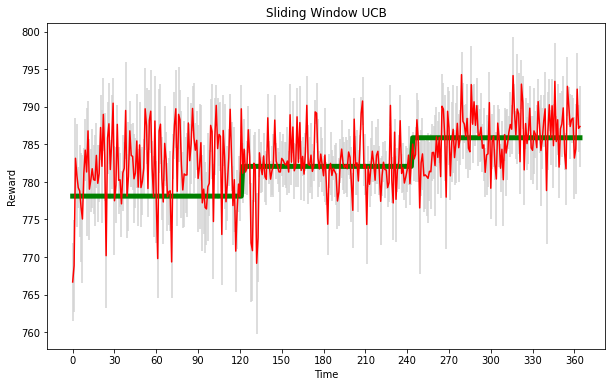

<Figure size 720x432 with 0 Axes>

In [181]:

plt.figure(figsize=(10, 6)) 

time_periods = range(len(SW_mean_rewards_per_round))

for t in time_periods:
    mean = SW_mean_rewards_per_round[t]
    std_dev = SW_std_dev_rewards_per_round[t]
    plt.vlines(t, mean - std_dev, mean + std_dev, color='lightgrey')


plt.plot(time_periods, optimum_means, color='green', linestyle='-', linewidth=5)
plt.plot(time_periods, SW_mean_rewards_per_round, color='red', linestyle='-')



plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Sliding Window UCB')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()

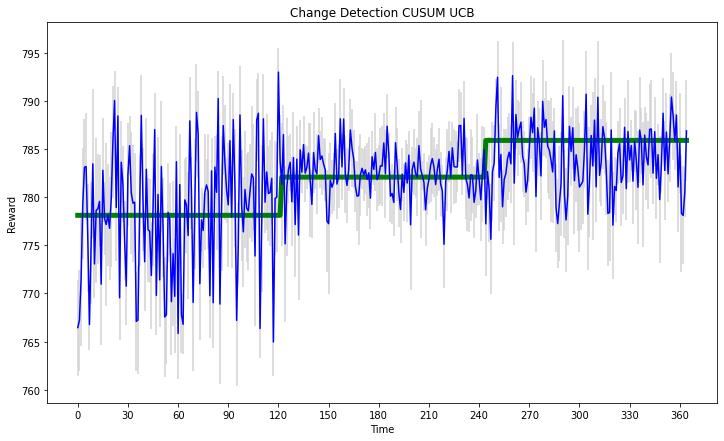

<Figure size 720x432 with 0 Axes>

In [180]:
plt.figure(figsize=(12, 7))


time_periods = range(len(CUSUM_mean_rewards_per_round))

for t in time_periods:
    mean = CUSUM_mean_rewards_per_round[t]
    std_dev = CUSUM_std_dev_rewards_per_round[t]
    plt.vlines(t, mean - std_dev, mean + std_dev, color='lightgrey')


plt.plot(time_periods, optimum_means, color='green', linestyle='-', linewidth=5)
plt.plot(time_periods, CUSUM_mean_rewards_per_round, color='blue', linestyle='-')




plt.xlabel('Time')
plt.ylabel('Reward')
plt.title('Change Detection CUSUM UCB')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()

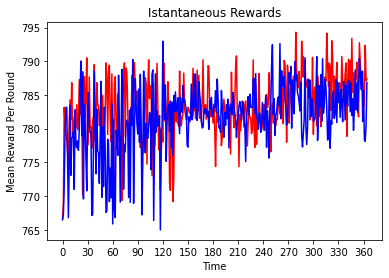

<Figure size 720x432 with 0 Axes>

In [162]:

time_periods = range(len(SW_mean_rewards_per_round))

plt.plot(time_periods, SW_mean_rewards_per_round, color='red', linestyle='-', label = "SW_UCB")
plt.plot(time_periods, CUSUM_mean_rewards_per_round, color="blue",linestyle="-", label = "CD_UCB")

plt.xlabel('Time')
plt.ylabel('Mean Reward Per Round')
plt.title('Istantaneous Rewards')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()


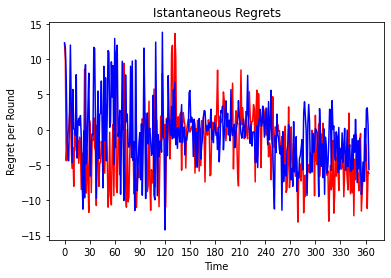

<Figure size 720x432 with 0 Axes>

In [116]:
time_periods = range(len(SW_mean_rewards_per_round))

plt.plot(time_periods, [x - y for x, y in zip(optimum_means, SW_mean_rewards_per_round)], color='red', linestyle='-', label = "SW_UCB")
plt.plot(time_periods, [x - y for x, y in zip(optimum_means, CUSUM_mean_rewards_per_round)], color="blue",linestyle="-", label = "CD_UCB")

plt.xlabel('Time')
plt.ylabel('Regret per Round')
plt.title('Istantaneous Regrets')

plt.xticks(time_periods[::30])

plt.figure(figsize=(10, 6))

plt.show()


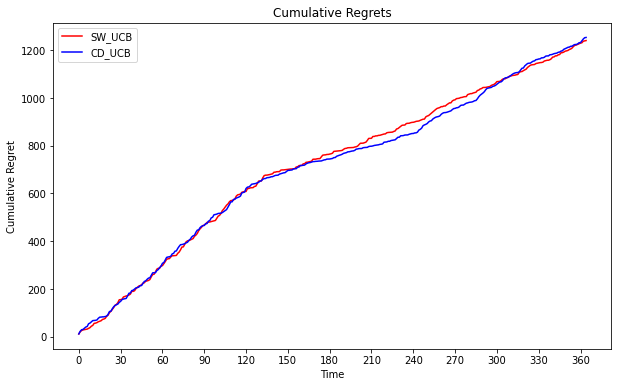

<Figure size 720x432 with 0 Axes>

In [174]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))  


SW_cumulative_regret = [sum([abs(x - y) for x, y in zip(optimum_means[:t+1], SW_mean_rewards_per_round[:t+1])]) for t in time_periods]
CD_cumulative_regret = [sum([abs(x - y) for x, y in zip(optimum_means[:t+1], CUSUM_mean_rewards_per_round[:t+1])]) for t in time_periods]

plt.plot(time_periods, SW_cumulative_regret, color='red', linestyle='-', label="SW_UCB")
plt.plot(time_periods, CD_cumulative_regret, color="blue", linestyle="-", label="CD_UCB")

plt.xlabel('Time')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regrets')

plt.xticks(time_periods[::30])
plt.legend()

plt.figure(figsize=(10, 6))
plt.show()
